In [1]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

!unzip cartoon-faces-googles-cartoon-set.zip -d cartoon_faces_dataset


Streaming output truncated to the last 5000 lines.
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9241369635511208616.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9241944887490894642.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242341144381494552.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242721282876118063.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242724767079327023.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242747830253082200.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242822867113421129.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9242996991614141095.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9243303694280080212.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9243342474858925237.jpg  
  inflating: cartoon_faces_dataset/cartoonset100k_jpg/9/cs9243791274208387689.jpg  
  inflating: cartoon_face

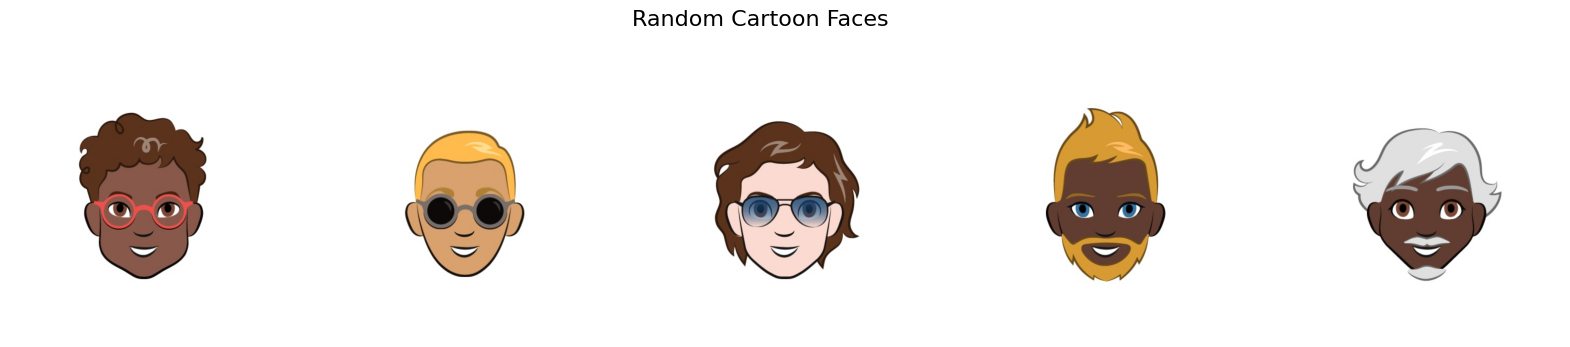

In [31]:
import random
from PIL import Image
import matplotlib.pyplot as plt

cartoon_faces_path = 'cartoon_faces_dataset/cartoonset100k_jpg'

def display_images(images, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 4))
    if title:
        fig.suptitle(title, fontsize=16)
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

all_images = []
for folder in os.listdir(cartoon_faces_path):
    folder_path = os.path.join(cartoon_faces_path, folder)
    if os.path.isdir(folder_path):
        all_images.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])

random_images_paths = random.sample(all_images, 5)
random_images = [Image.open(img_path).convert('RGB') for img_path in random_images_paths]

display_images(random_images, title="Random Cartoon Faces")


In [41]:
import numpy as np

for i, img in enumerate(random_images):
    img_array = np.array(img)
    print(f"Shape of image {i+1}: {img_array.shape}")


Shape of image 1: (500, 500, 3)
Shape of image 2: (500, 500, 3)
Shape of image 3: (500, 500, 3)
Shape of image 4: (500, 500, 3)
Shape of image 5: (500, 500, 3)


In [2]:
!pip install torchsummary

In [3]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

cartoon_faces_path = 'cartoon_faces_dataset/cartoonset100k_jpg'

class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    AddGaussianNoise(0., 0.03)
])

class CartoonFacesDataset(Dataset):
    def __init__(self, root, folders, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = []
        for folder in folders:
            folder_path = os.path.join(root, folder)
            self.image_files += [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  

selected_folders = ['0', '1', '2', '3', '4']

'''
# Select 5 random folders from the dataset
all_folders = [str(i) for i in range(10)]
selected_folders = random.sample(all_folders, 5)
print(f'Selected folders: {selected_folders}')
'''
dataset = CartoonFacesDataset(root=cartoon_faces_path, folders=selected_folders, transform=transform)

train_size = len(dataset)
train_dataset = dataset

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {len(train_dataset)}')

Total dataset size: 50000
Training dataset size: 50000


In [14]:
latent_dim = 40



class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2_mean = nn.Linear(256, latent_dim)
        self.fc2_log_var = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.flatten(x)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        z_mean = self.fc2_mean(x)
        z_log_var = self.fc2_log_var(x)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 8 * 8 * 128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_layer = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

    def forward(self, z):
        x = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = x.view(-1, 128, 8, 8)
        x = F.leaky_relu(self.deconv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.deconv3(x), negative_slope=0.2)
        x = torch.sigmoid(self.final_layer(x))
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = kl_loss.mean()  
        return reconstructed, kl_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
vae = VAE(encoder, decoder).to(device)

summary(vae, (3, 64, 64))

reconstruction_loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)



losses = []
reconstruction_losses = []
kl_losses = []

num_epochs = 12
for epoch in range(num_epochs):
    total_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, kl_loss = vae(images)
        reconstruction_loss = reconstruction_loss_fn(reconstructed, images)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_reconstruction_loss = total_reconstruction_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    losses.append(avg_loss)
    reconstruction_losses.append(avg_reconstruction_loss)
    kl_losses.append(avg_kl_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f' - Loss: {avg_loss:.4f} - Reconstruction Loss: {avg_reconstruction_loss:.4f} ')





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3          [-1, 128, 16, 16]          73,856
           Flatten-4                 [-1, 8192]               0
            Linear-5                  [-1, 256]       2,097,408
            Linear-6                   [-1, 40]          10,280
            Linear-7                   [-1, 40]          10,280
           Encoder-8       [[-1, 40], [-1, 40]]               0
            Linear-9                  [-1, 256]          10,496
           Linear-10                 [-1, 8192]       2,105,344
  ConvTranspose2d-11           [-1, 64, 16, 16]          73,792
  ConvTranspose2d-12           [-1, 32, 32, 32]          18,464
  ConvTranspose2d-13           [-1, 32, 64, 64]           9,248
  ConvTranspose2d-14            [-1, 3,

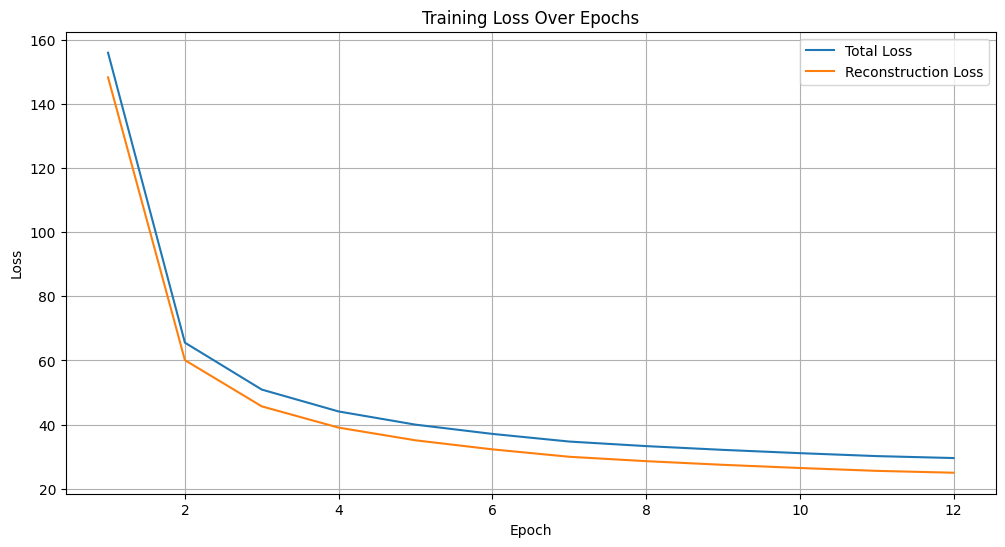

In [34]:

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


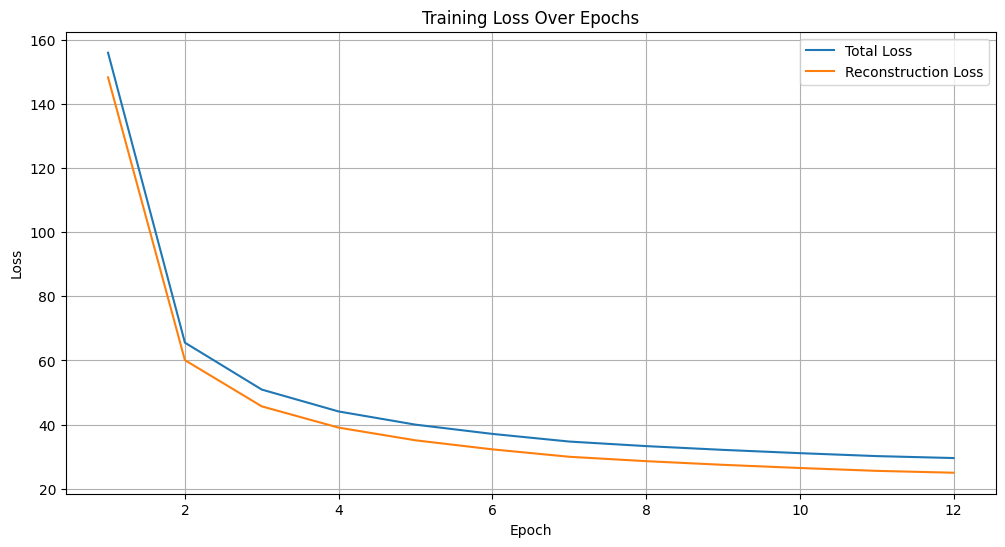

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


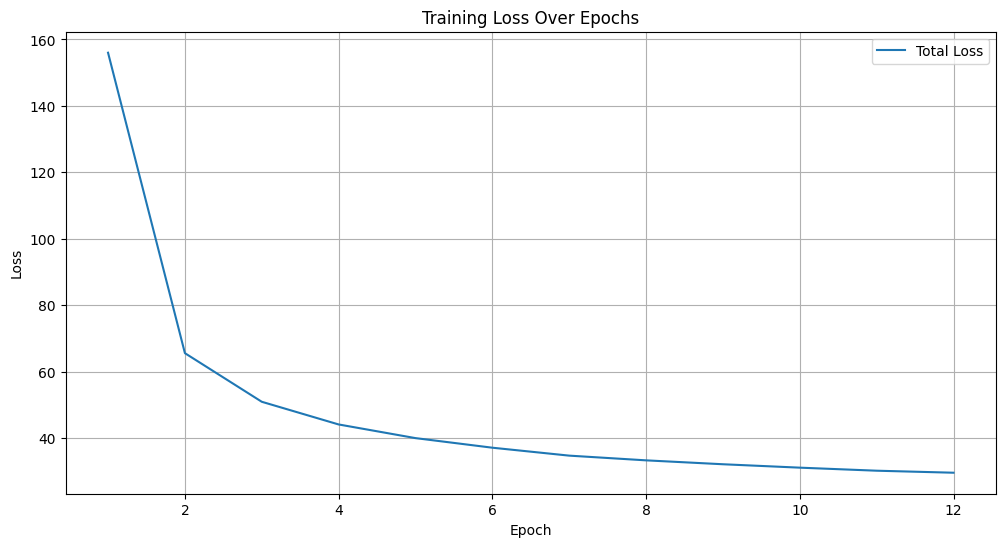

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

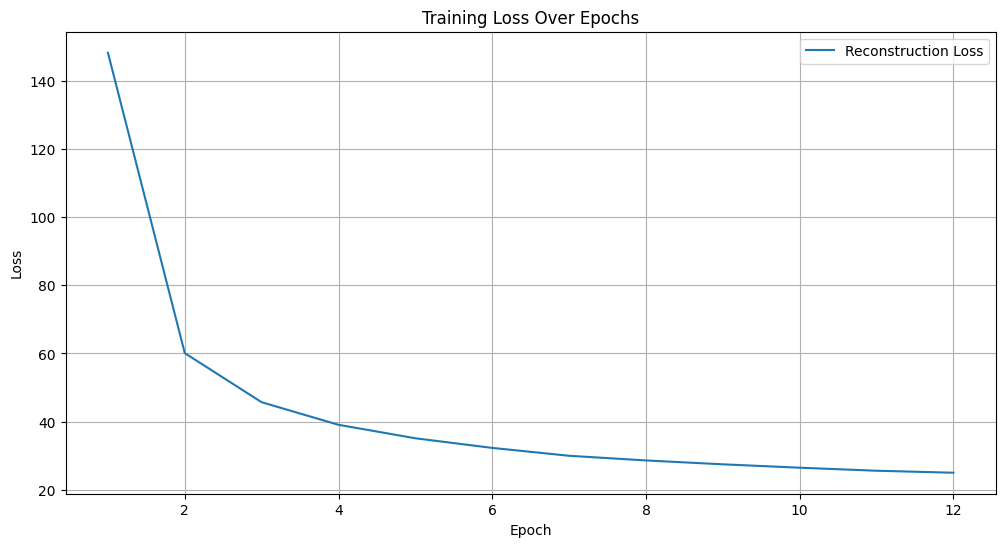

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Generated Images


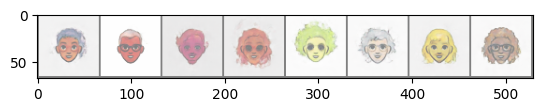

In [16]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
torch.save(vae.state_dict(), 'vae_anime_faces.pth')

vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    generated_images = decoder(z)

def show_image(img):
    img = img / 2 + 0.5  
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Generated Images")
show_image(utils.make_grid(generated_images.cpu()))

Generated Images


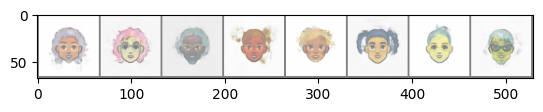

In [6]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
torch.save(vae.state_dict(), 'vae_anime_faces.pth')

vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    generated_images = decoder(z)

def show_image(img):
    img = img / 2 + 0.5  
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Generated Images")
show_image(utils.make_grid(generated_images.cpu()))

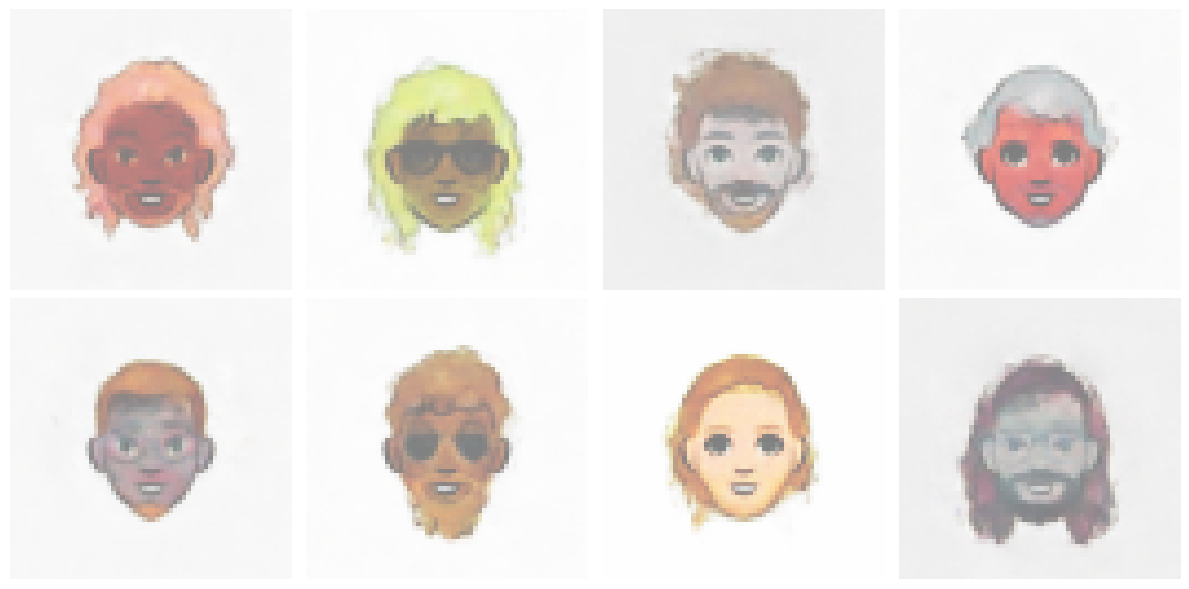

In [30]:
torch.save(vae.state_dict(), 'vae_anime_faces.pth')

vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   
    generated_images = decoder(z)

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

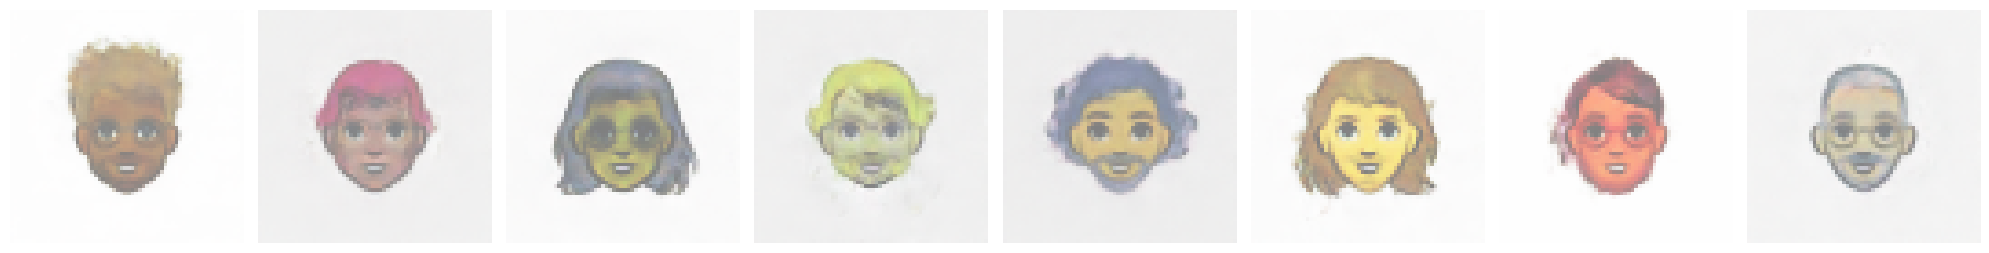

In [21]:
vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)   
    generated_images = decoder(z)

fig, axes = plt.subplots(1, 8, figsize=(20, 4))  
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


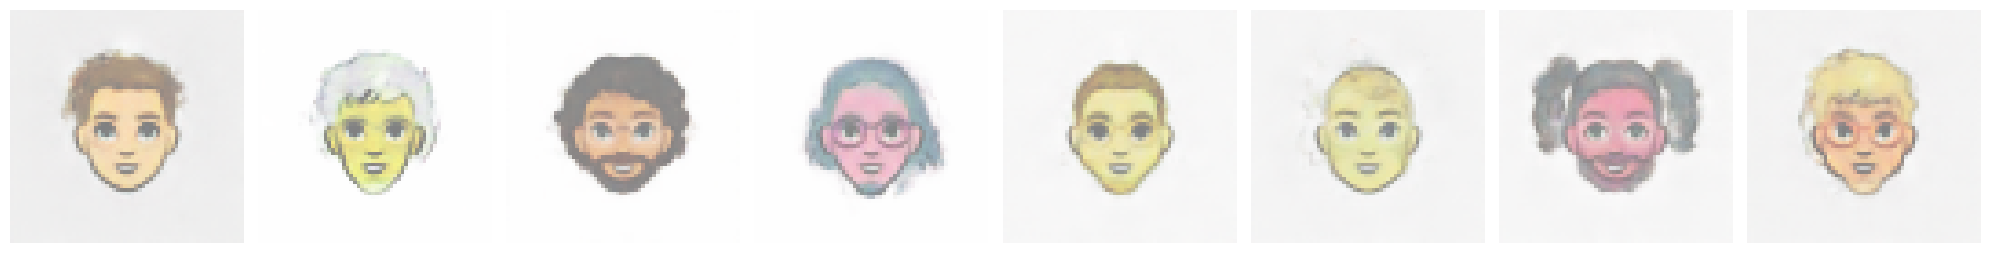

In [18]:

vae.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)  
    generated_images = decoder(z)


fig, axes = plt.subplots(1, 8, figsize=(20, 4)) 
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = generated_images[i] / 2 + 0.5  
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()